In [1]:
import matplotlib.pyplot as plt
import numpy.linalg as la
import numpy as np
import cv2

In [2]:
def plot_snake(ax, V, fill='green', line='red', alpha=1, with_txt=False):
    """ plots the snake onto a sub-plot
    :param ax: subplot (fig.add_subplot(abc))
    :param V: point locations ( [ (x0, y0), (x1, y1), ... (xn, yn)]
    :param fill: point color
    :param line: line color
    :param alpha: [0 .. 1]
    :param with_txt: if True plot numbers as well
    :return:
    """
    V_plt = np.append(V.reshape(-1), V[0,:]).reshape((-1, 2))
    ax.plot(V_plt[:,0], V_plt[:,1], color=line, alpha=alpha)
    ax.scatter(V[:,0], V[:,1], color=fill,
               edgecolors='black',
               linewidth=2, s=50, alpha=alpha)
    if with_txt:
        for i, (x, y) in enumerate(V):
            ax.text(x, y, str(i))


In [528]:
def load_data(fpath, radius):
    """
    :param fpath:
    :param radius:
    :return:
    """
    Im = cv2.imread(fpath, 0)
    h, w = Im.shape
    n = 25  # number of points
    u = lambda i: radius * np.cos(i) + w / 2
    v = lambda i: radius * np.sin(i) + h / 2
    V = np.array([(u(i), v(i)) for i in np.linspace(0, 2 * np.pi, n + 1)][0:-1], 'int32')

    return Im, V

In [543]:
def get_neighborhood(img, coord_V, window_size):
    neighborhood_coords = np.zeros((window_size**2, 2), dtype="int16")
    i = 0
    for x in range(-(window_size//2), window_size//2+1):
        for y in range(-(window_size//2), window_size//2+1):
            neighborhood_coords[i] = [int(coord_V[0]) + x, int(coord_V[1] + y)]
            i += 1
    return neighborhood_coords


def external_energy(img, V, window_size):
    blur_img = cv2.GaussianBlur(img, (7, 7), 3)
    G_x, G_y = cv2.Sobel(blur_img, cv2.CV_64F, 1, 0, ksize=3), cv2.Sobel(blur_img, cv2.CV_64F, 0, 1, ksize=3)

    G = -(G_x**2 + G_y**2)

    U = np.zeros((V.shape[0], window_size**2)).astype("float64")
    for n in range(U.shape[0]):
        neighborhood = get_neighborhood(img, V[n], window_size)
        for k in range(U.shape[1]):
            U[n][k] = G[neighborhood[k][1]][neighborhood[k][0]]
    return U

def internal_energy(img, V, window_size, alpha=0.001):
    P = np.zeros((V.shape[0], window_size**2, window_size**2))
    V = V.astype("float64")
    avg_dist = np.mean([np.linalg.norm(V[i] - V[i + 1]) for i in range(V.shape[0]-1)])
    
    for n in range(P.shape[0]-1):
        neighborhood_1 = get_neighborhood(img, V[n], window_size)
        neighborhood_2 = get_neighborhood(img, V[n+1], window_size)
        for k in range(P.shape[1]):
            for l in range(P.shape[1]):
                if k != l:
                    P[n][k][l] = alpha * (np.linalg.norm(neighborhood_2[k] - neighborhood_1[l])  - avg_dist)
                else:
                    P[n][k][l] = np.inf
    return P

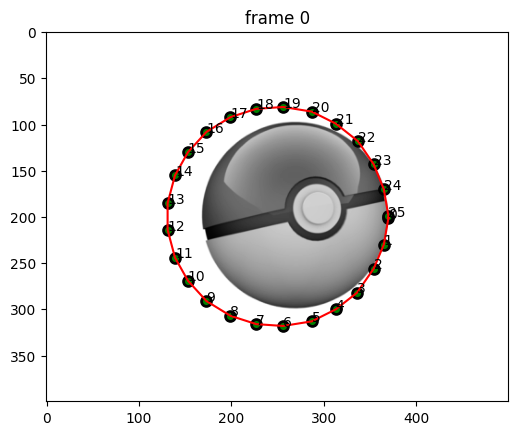

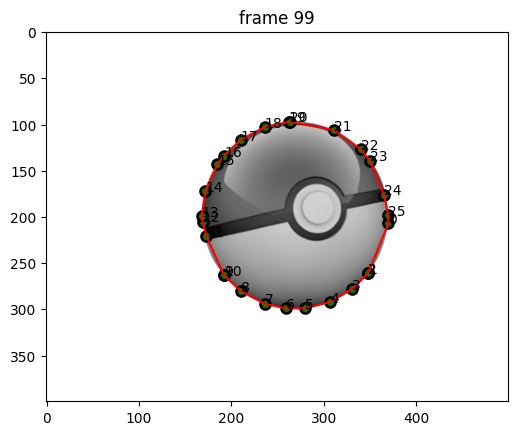

In [545]:
def run(fpath, radius):
    """ run experiment
    :param fpath:
    :param radius:
    :return:
    """
    Im, V = load_data(fpath, radius)
    window_size = 3

    V = list(V)
    V.append(list(V[0].copy()))
    V = np.array(V)

    n_steps = 100
    alpha = 2


    for t in range(n_steps):
        int_energy = np.array(internal_energy(Im, V, window_size, alpha)) # P
        ext_energy = np.array(external_energy(Im, V, window_size)) # U
    
        S = np.zeros(ext_energy.shape)
        m = np.zeros((S.shape[0], S.shape[1]))
        S[0] = ext_energy[0]
        for n in range(1, S.shape[0]):
            for k in range(S.shape[1]):
                S[n][k] = np.min(ext_energy[n][k] + S[n-1] + int_energy[n-1][k])
                m[n][k] = np.argmin(ext_energy[n][k] + S[n-1] + int_energy[n-1][k])
            

        min_S_curr = int(np.argmin(S[-1]))
        snake = []

        for i in range(m.shape[0]-1, -1, -1):
            V_n = get_neighborhood(Im, V[i], window_size).reshape(-1, 2).astype("uint32")[min_S_curr]
            snake.insert(0, V_n)
            min_S_curr = int(m[i][min_S_curr])
        V = np.array(snake)
        

        if t ==0 or t==n_steps-1:
            plt.clf()
            plt.imshow(Im, cmap='gray')
            plt.title('frame ' + str(t))
            plot_snake(plt, V, with_txt=True)
            plt.pause(0.01)



    plt.pause(2)

run('../images/ball.png', radius=120)
# run('../images/coffee.png', radius=100)


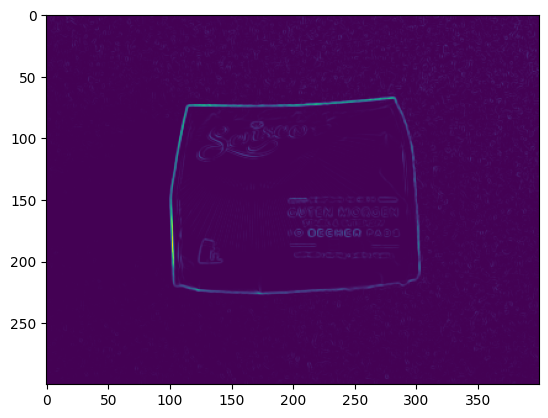

In [548]:
img = cv2.imread("../images/coffee.png", 0)
blur_img = cv2.GaussianBlur(img, (7, 7), 0.1)
G_x, G_y = cv2.Sobel(blur_img, cv2.CV_64F, 1, 0, ksize=3).astype("float64"), cv2.Sobel(blur_img, cv2.CV_64F, 0, 1, ksize=3).astype("float64")


plt.imshow(G_x**2 + G_y**2)